In [5]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import pack_vis_sol
import pack_dynamics
import copy
import time
import pack_io
import pandas as pd
from IPython.display import HTML, display, clear_output
kgs.set_float32(False)
kgs.TREE_EXPANSION = kgs.TREE_EXPANSION**2
print(kgs.TREE_EXPANSION)
kgs.initialize_tree_globals()
import pack_cuda
pack_cuda._ensure_initialized()


3.999999999341867e-10


In [6]:
N=7
xyt = kgs.dill_load(kgs.code_dir + '../res/mine.pickle')[0][N-1].xyt
sol = kgs.SolutionCollectionSquare()
sol.xyt = xyt.astype(kgs.dtype_cp)
sol.snap()
sol.check_constraints()
mine = sol.h[0,0].get().item()**2/N
theirs = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.code_dir + '../res/70.32.csv'))[1][N-1]

In [7]:
mine, theirs, 0.399842

(0.39989701176031645, 0.3998965505210908, 0.399842)

Before optimization:  0.02799279082322215 0.0 1.6731046238422196


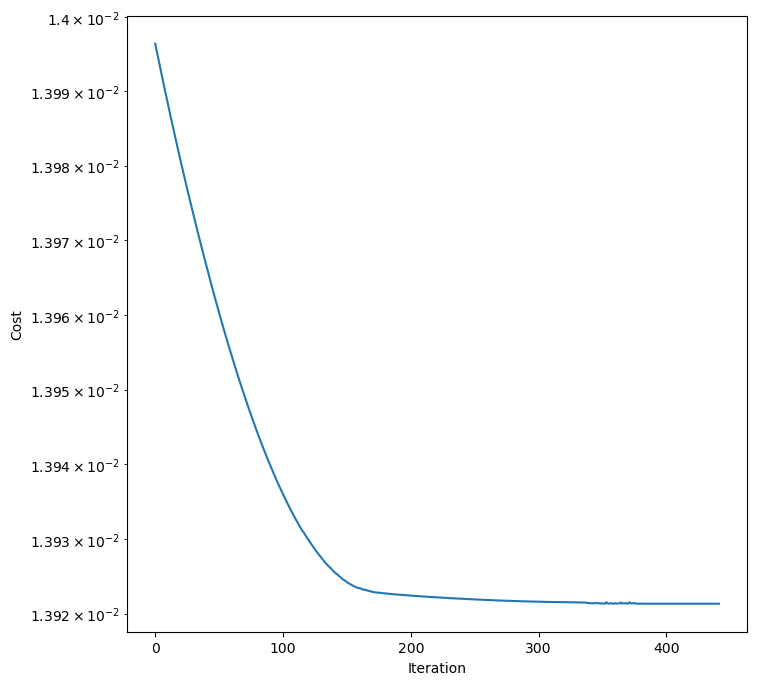

After optimization:  0.027770891074345334 7.178865333114768e-05 1.664304732343635


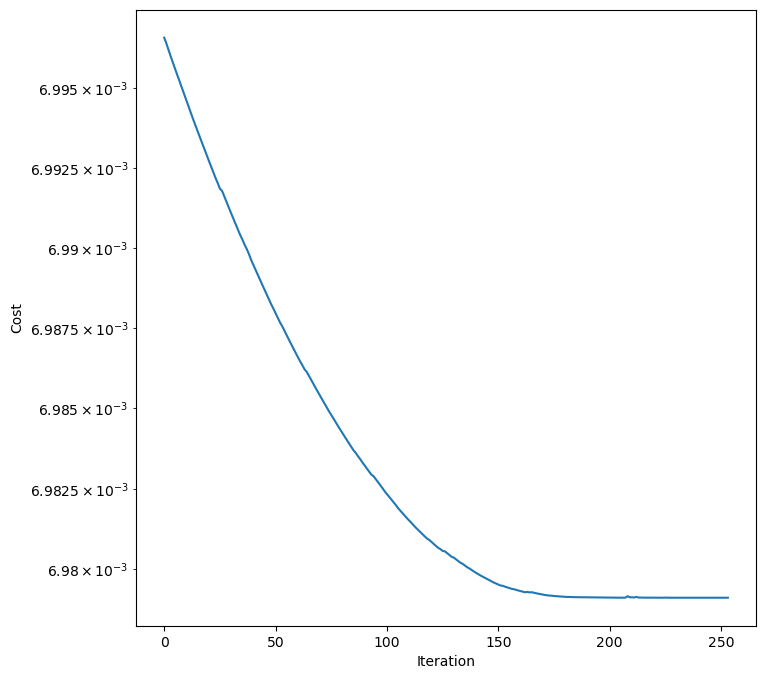

After optimization:  0.027860511112741713 1.862987328539715e-05 1.668588662296862


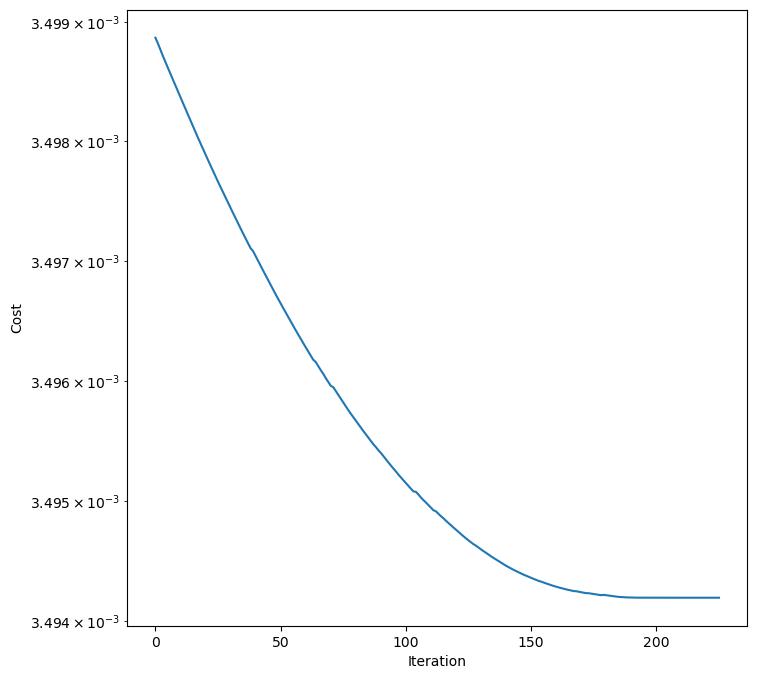

After optimization:  0.02792114546732058 4.626747033142015e-06 1.6708237106375836


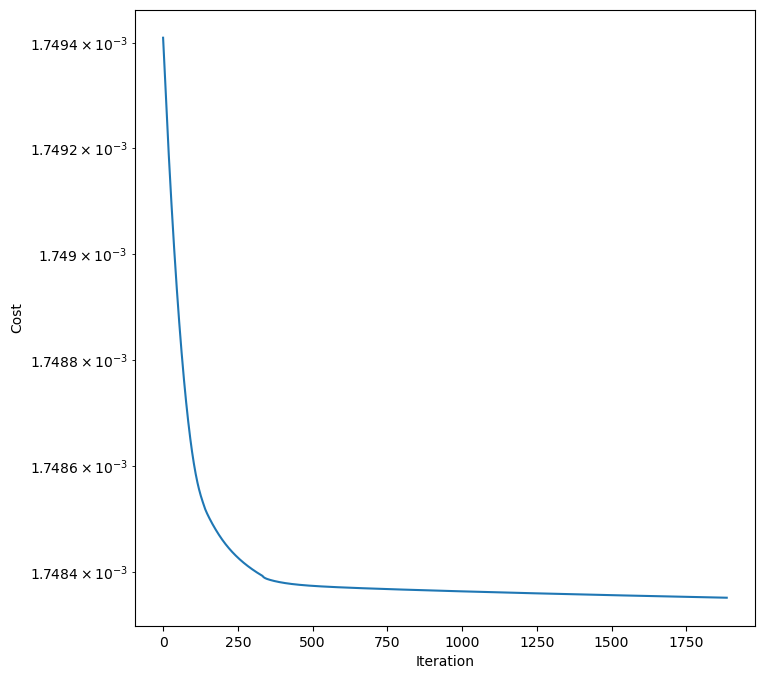

After optimization:  0.02795291928909842 1.3797735606549501e-06 1.6718713920495727


In [ ]:
def legalize(sol, do_plot=False, move_factor=10., tolerance_rel_change=1e-7, stop_on_cost_increase = False, n_iter=20, target=1e-10, validate=True):
    assert sol.is_phenotype()
    solx = copy.deepcopy(sol)
    solx.use_fixed_h = False
    solx.snap()
    import pack_ga3
    ga = pack_ga3.baseline()
    cost = copy.deepcopy(ga.fitness_cost)
    cost.costs[2] = pack_cost.CollisionCostSeparation()
    #cost.costs[0].scaling*=0.1
    cost_overlap = copy.deepcopy(cost)
    cost_overlap.costs.pop(0)
    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = copy.deepcopy(cost)
    optimizer.n_iterations = 20000
    optimizer.max_step = 1e-4*1e20
    optimizer.history_size = 10
    optimizer.tolerance_rel_change = tolerance_rel_change
    optimizer.track_cost = do_plot
    optimizer.plot_cost = do_plot
    optimizer.use_line_search = True
    optimizer.stop_on_cost_increase = stop_on_cost_increase
    print("Before optimization: ", cost.compute_cost_allocate(solx)[0].get().item(), cost_overlap.compute_cost_allocate(solx)[0].get().item(), solx.h[0,0])
    for _ in range(n_iter):
        optimizer.cost.costs[0].scaling*=0.5
        optimizer.max_step*=0.5
        solx = optimizer.run_simulation(solx)
        optimizer.n_iterations = np.round(200*move_factor).astype(int)
        print("After optimization: ", cost.compute_cost_allocate(solx)[0].get().item(), cost_overlap.compute_cost_allocate(solx)[0].get().item(), solx.h[0,0])
        if cost_overlap.compute_cost_allocate(solx)[0].get().item()<target:
            break   
    try:
        if validate:
            solution_list_to_dataframe([solx], compact=False)
        else:
            assert cost_overlap.compute_cost_allocate(solx)[0].get().item()<target
        return solx
    except:
        if tolerance_rel_change==0.:
            raise Exception('Could not legalize solution')
        else:
            return legalize(solx, do_plot=do_plot, move_factor=move_factor, tolerance_rel_change=0., stop_on_cost_increase=stop_on_cost_increase, n_iter=n_iter, target=target, validate=validate)

sol2 = legalize(sol, do_plot = True, validate=False, target = 1e-20, n_iter = 100, tolerance_rel_change=1e-10)

In [ ]:
pack_io.solution_list_to_dataframe([sol], compact=True);
pack_io.solution_list_to_dataframe([sol2], compact=True);

Score of generated dataframe: 0.3998863152828664
Score of generated dataframe: 0.39988579262753693


In [10]:
solx = copy.deepcopy(sol)
solx.use_fixed_h = False
solx.snap()
import pack_ga3
ga = pack_ga3.baseline()
cost = copy.deepcopy(ga.fitness_cost)
cost.costs[2] = pack_cost.CollisionCostSeparation()
cost.compute_cost_allocate(solx)[0].get().item()


0.02799279082322215